# Query Augmentation Tool: A Context-Aware Query Refinement System

The **Query Augmentation Tool** is an AI-driven workflow that enhances the accuracy and relevance of responses to user queries by identifying abbreviations, determining context, expanding terms, and refining queries. Built using the LangChain and LangGraph frameworks, this tool processes user inputs through a sequence of specialized agents, ensuring that abbreviations are accurately expanded, queries are aligned with specific contexts, and responses are optimized for effectiveness.

## Overview

The core functionality of the Query Augmentation Tool includes:

- **Identifying Abbreviations** in user queries, essential for interpreting field-specific terminology.
- **Determining Query Context** to distinguish fields such as Medicine, AI, or Technology.
- **Providing Context-Specific Definitions** by referencing a specialized knowledge base.
- **Augmenting the Query** when necessary to make it more comprehensive, allowing an LLM to generate a highly relevant response.

## Key Objectives

This tool is tailored to meet critical requirements in technical and academic environments where:

- **Precision in Query Interpretation**: By detecting abbreviations and determining context, the tool clarifies ambiguous terms that vary across fields.
- **Query Enhancement**: By dynamically refining the original query, the tool ensures that the query aligns closely with user intent, leading to more accurate responses.
- **Optimized Response Generation**: By enriching the query with specific context, the tool improves the relevance and quality of LLM responses.

## Workflow Structure

The Query Augmentation Tool is implemented as a structured graph of agents, each performing a unique function in the query enhancement pipeline:

1. **Jargon Agent**
   - **Purpose**: Scans the user query for abbreviations or shorthand terms.
   - **Output**: If abbreviations are found, they are tagged with a prefix, `ABBREVIATIONS_USED`; if no abbreviations are detected, the response is `NO_ABBREVIATIONS_USED_IN_QUERY`.
   - **Utility**: This initial step ensures any abbreviations are flagged early, preparing the query for accurate context matching.

2. **Context Agent**
   - **Purpose**: Assigns the most relevant context for the query from predefined options (e.g., "Medical," "Technology," "AI").
   - **Output**: Tags the output with `CONTEXT_MATCHED` and the identified context, such as `CONTEXT_MATCHED: Medical`.
   - **Utility**: Correct context assignment allows for precise interpretation of abbreviations, especially terms with varied meanings across fields.

3. **Search Agent**
   - **Purpose**: Searches for definitions or meanings of abbreviations based on the identified context.
   - **Output**: Returns the definition if a match is found in the context-specific dictionary; if not, it responds with `NO SUCH WORD EXISTS, PLEASE CHECK SPELLING`.
   - **Utility**: Accurate abbreviation expansion is ensured by conducting a targeted search within the correct context.

4. **New Query Agent**
   - **Purpose**: Enhances the original query by integrating contextually relevant information. If no term matches, it modifies the query based on internal resources.
   - **Output**: Returns a refined query prefixed with `NEW_QUERY`, optimized for downstream LLM response generation.
   - **Utility**: This agent bridges the gap between user intent and system response, tailoring the query to drive accurate LLM-generated answers.

## Example Workflow Execution

**Input Query**: “I am doing medical research. Tell me about RAG.”

1. **Jargon Agent** detects "RAG" as an abbreviation.
2. **Context Agent** identifies "Medical" as the context based on the query.
3. **Search Agent** retrieves the medical definition of "RAG" (e.g., "Reproductive Anisole Generation").
4. **New Query Agent** augments the query to “Tell me about Reproductive Anisole Generation in a medical context,” ensuring relevance.

## Implementation Details

This workflow leverages LangChain's `ChatOpenAI` for model interaction and LangGraph for stateful graph management. Key implementation details include:

- **Function Definitions**: Each agent is implemented as a unique function, processing input and returning results with specific tags.
- **Graph Workflow**: The state graph, managed by LangGraph, directs the query through each agent sequentially, with each agent as a node.

### Key Dependencies

Install required libraries with:

```bash
!pip install langgraph langchain_community
!pip install langchain_openai
%pip install -qU duckduckgo-search langchain-community
```

### Usage Considerations

This tool is ideal for scenarios where:

- Context-specific abbreviations frequently occur.
- High precision in query interpretation is required, especially in specialized research.
- Enhanced query structure improves the accuracy and relevance of AI-generated responses.

### Future Enhancements

Potential updates to the Query Augmentation Tool include:

- **Dynamic Context Expansion**: Automatically adding new contexts or definitions from external knowledge sources.
- **Interactive Query Refinement**: Enabling users to verify or adjust context selections.
- **Real-Time Feedback Mechanism**: Introducing a feedback loop for continuous learning based on user interactions.

In [17]:
!pip install langgraph langchain_community

In [1]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.52.2
    Uninstalling openai-1.52.2:
      Successfully uninstalled openai-1.52.2


In [20]:
%pip install -qU duckduckgo-search langchain-community

In [2]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["TAVILY_API_KEY"] ="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"

In [16]:
import os
import getpass
from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"] = getpass.getpass()
model = ChatOpenAI(model="gpt-3.5-turbo")

··········


In [18]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START





# Updated create_jargon_agent
def create_jargon_agent(llm):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                "Your task is to identify any abbreviations or shorthands in the original user query."
                "If abbreviations are detected, pass them with the prefix 'ABBREVIATIONS_USED:'."
                "If no abbreviations are detected, pass 'NO_ABBREVIATIONS_USED_IN_QUERY:' along with the original user query."
                "You can access the original user query as needed for this identification."
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    return prompt | llm

# Updated create_context_agent
def create_context_agent(llm, CONTEXTS: list):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful assistant, tasked with identifying the context from a list: {CONTEXTS}."
                "Identify the matching context based on the original user'query"
                "Original Query: {original_query}"
                " and return it prefixed with 'CONTEXT_MATCHED:' "
                "along with the response from the previous assistant."
                "You can directly access the original user query and CONTEXTS for this process."
                "Strictly , you don't have to return any definition or description about abbreviation or user's query."
                "Just return contex matched."
            ),
        ]
    )
    prompt = prompt.partial(CONTEXTS=CONTEXTS)
    return prompt | llm

# Updated create_search_agent
def create_search_agent(llm, QUERY: dict):
    """Create an agent that retrieves definitions based on context."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                "You have only one task to do."
                "Read the CONTEXT and ABBREVIATIONS received from the previous assistant."
                "Original Query: {original_query}"
                "Use this dictionary {QUERY} to check if any matching abbreviation or shorthand definitions "
                "are relevant to the context derived from the previous assistant."
                "If a matching abbreviation in this context is found, return its definition; "
                "otherwise, respond with: NO SUCH WORD EXISTS, PLEASE CHECK SPELLING."
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(QUERY=QUERY)
    return prompt | llm


# Updated create_new_query_agent
def create_new_query_agent(llm):
    """Create an agent that adjusts the user's query based on context."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                "Your task is to adjust the original query if necessary."
                "Original Query: {original_query}"
                "If the previous assistant responded with 'NO SUCH WORD EXISTS, PLEASE CHECK SPELLING', "
                "use your internal knowledge to gather information on the abbreviation in the query in that particular context or field only."
                "Otherwise, enhance the query based on information provided by the previous assistant "
                "to make it clearer for the next assistant."
                "Return the modified query prefixed with 'NEW_QUERY:'."
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    return prompt | llm

In [19]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    original_query: str  # Store the original user query here

In [21]:
import functools

from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode




from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()
tool_node = ToolNode([search])


# Helper function to create a node for a given agent with dynamic tool binding
def agent_node(state, agent, name, tools=None):
    # Ensure the agent has access to the original query from the state
    state["original_query"] = state.get("original_query", "")

    # Invoke the agent with the current state (including original query)
    result = agent.invoke(state)

    # Format the result to be compatible with the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        # Append the name of the current node to the AIMessage
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)

    return {
        "messages": [result],
        # Include original query for use by next agent in the workflow
        "original_query": state["original_query"],
        "sender": name,
    }


CONTEXTS = ['Medical ','Technology','AI']
QUERY={
    'AI' : {'RAG': "means Retrieval Augmented Generation",
            'DAG':"means Dynamic Augmented Graph"
            },
    'Medical' : {
        'RAG': "means Reproductive Anisole Generation , which is a new mode of reproduction identified recently"
    },
    }

llm = ChatOpenAI(model="gpt-4o")

# Research agent and node
jargon_agent = create_jargon_agent(
    llm,
)
jargon_node = functools.partial(agent_node, agent=jargon_agent, name="Jargon")

# chart_generator
context_agent = create_context_agent(
    llm,
    CONTEXTS,
)
context_node = functools.partial(agent_node, agent=context_agent, name="context")


search_agent = create_search_agent(
    llm,
    QUERY,
)
search_node = functools.partial(agent_node, agent=search_agent, name="search")


new_query_agent = create_new_query_agent(
    llm
)
new_query_node = functools.partial(agent_node, agent=new_query_agent, name="new_query")

In [22]:
# Either agent can decide to end
from typing import Literal


def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    return "continue"

In [23]:
workflow = StateGraph(AgentState)

workflow.add_node("jargoner", jargon_node)
workflow.add_node("contextor", context_node)
workflow.add_node("searcher", search_node)
workflow.add_node("new_querier", new_query_node)

In [24]:
workflow.add_edge(START, "jargoner")
workflow.add_edge("jargoner", "contextor")
workflow.add_edge("contextor", "searcher")
workflow.add_edge("searcher", "new_querier")



In [25]:
graph = workflow.compile()

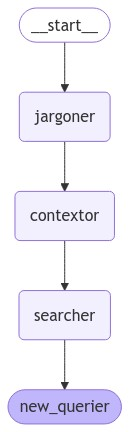

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(content="i am doing medical research . tell me about RAG")  # User query provided here
        ],
        "sender": "user",
        "original_query": "i am doing medical research . tell me about RAG",  # Store original query here in state
    },
    {"recursion_limit": 150},
)


# Process and print events
for s in events:
    print(s)
    print("----")

{'jargoner': {'messages': [AIMessage(content='ABBREVIATIONS_USED: RAG', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 107, 'total_tokens': 115, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'stop', 'logprobs': None}, name='Jargon', id='run-349cb814-ab12-4c3d-a885-47c44b0bf619-0', usage_metadata={'input_tokens': 107, 'output_tokens': 8, 'total_tokens': 115, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})], 'sender': 'Jargon', 'original_query': 'i am doing medical research . tell me about RAG'}}
----
{'contextor': {'messages': [AIMessage(content='CONTEXT_MATCHED: Medical', additional_kwargs={'refusal': None}, respon